In [1]:
import sys
import os
import time

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from urllib.request import urlretrieve
from scipy.stats import pearsonr

from config.config import DATA_PATH
pd.set_option('display.max_columns', None)

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [3]:
X_train = pd.read_csv(DATA_PATH + '/modeling/X_train.csv')
X_test = pd.read_csv(DATA_PATH + '/modeling/X_test.csv')
y_train = pd.read_csv(DATA_PATH + '/modeling/y_train.csv')
y_test = pd.read_csv(DATA_PATH + '/modeling/y_test.csv')
X_train_reduced = pd.read_csv(DATA_PATH + '/modeling/X_train_10.csv')
X_test_reduced = pd.read_csv(DATA_PATH + '/modeling/X_test_10.csv')

In [4]:
y_train = y_train['cancelled']
y_test = y_test['cancelled']

In [5]:
X_train.head()

,dep_delay_max_10D,origin_encoded,origin_division_encoded,hour_of_day,dep_window_encoded,wind_gusts_10m_origin,wind_gusts_10m_dest,wind_speed_10m_origin,wind_speed_10m_dest,airline_ops_encoded,airline_mkt_encoded,code_share_flight,temperature_2m_dest,temperature_2m_origin,month_encoded,n_flights_10D,quarter,visibility_origin,visibility_dest,origin_weather_impact_category,dest_weather_impact_category,route_id,distance,cancelled_sum_10D,snow_depth_dest,snow_depth_origin,precipitation_origin,wind_direction_10m_dest,wind_direction_10m_origin,precipitation_dest,is_holiday,day_of_week,div_airport_landings_sum_10D,day_of_month
0,-0.348602,1.086048,1.256926,-0.007048,-0.230172,-0.126427,-0.640642,0.743245,-0.156552,-0.611636,-0.400774,0,1.727398,1.284996,1.997376,-0.487927,0.436934,-0.305352,0.130512,-0.706343,-0.70741,-1.360225,-0.205859,-0.321406,-0.09764,-0.098455,-0.05996,0.312641,-0.883635,-0.061496,0,0.514201,-0.124875,1.398689
1,0.039187,-0.248256,-0.026065,-1.389845,-0.809685,-0.736177,-0.288606,-0.669820,0.126870,1.209472,2.051047,0,-0.135570,0.567060,0.183208,0.169054,0.436934,-0.940635,-0.445325,-0.706343,-0.70741,0.512240,-0.219666,-0.321406,-0.09764,-0.098455,-0.05996,1.651348,1.717016,-0.061496,0,0.014131,-0.124875,0.600410
2,1.733971,2.231095,2.044389,0.980665,1.115582,0.469142,0.401384,0.332172,-0.001958,0.461189,0.782093,0,0.852368,1.262560,-0.837515,-0.706921,-0.462329,1.798142,2.635167,0.900034,-0.70741,-0.446358,1.759337,-0.321406,-0.09764,-0.098455,-0.05996,-1.629994,0.716766,-0.061496,0,0.514201,-0.124875,-0.425949
3,-0.750754,0.134208,-0.170807,1.375750,1.843912,2.184949,-1.133492,0.589093,-1.109879,-0.611636,-0.400774,0,-0.000081,-0.425711,-1.112765,-0.487927,1.336197,-0.898283,-0.979027,0.900034,-0.70741,-0.552593,1.378877,-0.321406,-0.09764,-0.098455,-0.05996,-0.150370,0.036596,-0.061496,0,0.014131,-0.124875,0.372330
4,-0.391690,0.134208,-0.170807,-0.204590,-1.113213,0.100457,0.499954,0.383556,1.621276,-0.611636,-0.400774,0,0.366867,1.268169,0.183208,-0.487927,0.436934,-0.361822,-0.702813,-0.706343,-0.70741,-0.528364,1.532288,-0.321406,-0.09764,-0.098455,-0.05996,1.047420,0.346673,-0.061496,1,-1.486076,-0.124875,-1.338268


In [6]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

## Model Selection, Evaluation and GridSearch Functions

In [7]:
cross_val_results = pd.DataFrame(columns=['model_name', 'model', 'mean_f1', 'mean_recall', 'mean_precision'])

In [8]:
def cross_validate_model(model_name, model, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scoring = ['f1', 'recall', 'precision']

    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)

    mean_f1 = scores['test_f1'].mean()
    mean_recall = scores['test_recall'].mean()
    mean_precision = scores['test_precision'].mean()

    cross_val_results.loc[len(cross_val_results)] = [model_name, model, mean_f1, mean_recall, mean_precision]

    return cross_val_results


In [9]:
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, params=None):


    start_time = time.time()

    if params:
        model.set_params(**params)

    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    auprc = average_precision_score(y_test, y_pred_proba[:,1])

    feature_importances_df = None
    if hasattr(model, "feature_importances_"):        
        data = list(zip(X_test.columns, model.feature_importances_))
        feature_importances_df = pd.DataFrame(data=data, columns=['Feature', 'Feature Importance'])
    
    metrics =  {
        'model_name': model_name,
        'model': model, 
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'auprc': auprc,
        'parameters': params if params else dict(model.get_params()),
        'training_testing_time_seconds': elapsed_time

    }

    print(f'Results for {model_name} model:')
    print('Classifcation report: \n', classification_report(y_test, y_pred))
    print()
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

    return pd.DataFrame([metrics]), y_pred, y_pred_proba, feature_importances_df



In [10]:
def grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    gs = GridSearchCV(model, param_grid=params, cv=kf, scoring='recall', n_jobs=-1)

    gs_fit = gs.fit(X_train, y_train)

    best_estimator, best_params = gs_fit.best_estimator_, gs_fit.best_params_

    return best_estimator, best_params

In [11]:
from sklearn.model_selection import RandomizedSearchCV

def random_grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

    rs  = RandomizedSearchCV(model, params, n_iter=50, n_jobs=-1, cv=kf)

    rs_fit = rs.fit(X_train, y_train)

    best_estimator, best_params = rs_fit.best_estimator_, rs_fit.best_params_

    return best_estimator, best_params

# Baseline Models & Performance

In [12]:
models_dict = {
    'LogReg_base_cv': LogisticRegression(random_state=44),
    'RF_base_cv': RandomForestClassifier(random_state=44),
    'GB_base_cv': GradientBoostingClassifier(random_state=44),
    'Balanced_RF_cv': BalancedRandomForestClassifier(random_state=44),
    'Easy_Ensemble_cv': EasyEnsembleClassifier(random_state=44)
}

In [13]:
for name, model in models_dict.items():
    cross_val_results = cross_validate_model(name, model, X_train, y_train)

top_models = cross_val_results.sort_values(by="mean_f1", ascending=False)


/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementat

In [14]:
top_models

,model_name,model,mean_f1,mean_recall,mean_precision
1,RF_base_cv,RandomForestClassifier(random_state=44),0.256012,0.151387,0.830568
3,Balanced_RF_cv,BalancedRandomForestClassifier(random_state=44),0.189988,0.999138,0.104975
4,Easy_Ensemble_cv,EasyEnsembleClassifier(random_state=44),0.187791,1.000000,0.103626
2,GB_base_cv,GradientBoostingClassifier(random_state=44),0.166303,0.094004,0.723032
0,LogReg_base_cv,LogisticRegression(random_state=44),0.079048,0.046239,0.272165


# Evaluate Best Base Models

In [168]:
rf_model = RandomForestClassifier(random_state=44)

rf_base_result, y_pred_rf_base, y_pred_proba_rf_base, rf_feature_importances = evaluate_model('RF_base', rf_model, X_train, y_train, X_test, y_test)

Results for RF_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    442725
           1       0.86      0.18      0.30      6460

    accuracy                           0.99    449185
   macro avg       0.92      0.59      0.65    449185
weighted avg       0.99      0.99      0.98    449185


Confusion matrix: 
 [[442530    195]
 [  5280   1180]]


In [ ]:
model_results = rf_base_result

In [16]:
balanced_rf_model = BalancedRandomForestClassifier(random_state=44)

balanced_rf_result, y_pred, y_pred_proba, balanced_rf_feature_importances = evaluate_model('Balanced_RF_base', balanced_rf_model, X_train, y_train, X_test, y_test)


/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementat

Results for Balanced_RF_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    442725
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[387765  54960]
 [    10   6450]]


In [18]:
model_results = pd.concat([model_results, balanced_rf_result], axis=0, ignore_index=True)

In [19]:
easy_ens_model = EasyEnsembleClassifier(random_state=44)

easy_ens_base_result, y_pred, y_pred_proba, _ = evaluate_model('Easy_Ensemble_base', easy_ens_model, X_train, y_train, X_test, y_test)


Results for Easy_Ensemble_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    442725
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[386779  55946]
 [     0   6460]]


In [20]:
model_results = pd.concat([model_results, easy_ens_base_result], axis=0, ignore_index=True)

In [21]:
gb_model = GradientBoostingClassifier(random_state=44)

gb_base_result, y_pred_gb, y_pred_proba_gb, gb_feature_importances = evaluate_model('GB_base', gb_model, X_train, y_train, X_test, y_test)


Results for GB_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    442725
           1       0.71      0.10      0.17      6460

    accuracy                           0.99    449185
   macro avg       0.85      0.55      0.58    449185
weighted avg       0.98      0.99      0.98    449185


Confusion matrix: 
 [[442473    252]
 [  5843    617]]


In [22]:
model_results = pd.concat([model_results, gb_base_result], axis=0, ignore_index=True)

In [23]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875450,0.103516,1.000000,0.187611,0.966530,0.272810,"{'estimator': None, 'n_estimators': 10, 'n_job...",25.734644
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877623,0.105032,0.998452,0.190069,0.973046,0.363237,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",15.052239
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987811,0.858182,0.182663,0.301213,0.977415,0.527714,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",74.759576
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986431,0.710012,0.095511,0.168372,0.971780,0.379870,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",210.110650


In [24]:
model_results.to_csv('./model_results/model_results.10.25_v1.csv', index=False)

# Hyper Parameter Tuning

In [25]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.3, random_state=42)
for train_index, _ in sss.split(X_train, y_train):
    X_train_sample, y_train_sample = X_train.iloc[train_index], y_train.iloc[train_index]

In [26]:
rf_param_grid = {
    'n_estimators':[350, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth':[10, 20, None],
    'max_features':['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1], 
    'random_state':[40]}

rf_best_model, rf_best_params = grid_search_model(RandomForestClassifier(random_state=44), params=rf_param_grid, X_train=X_train_sample, y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [27]:
rf_best_params

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'n_jobs': -1,
 'random_state': 40}

In [28]:
rf_metrics, y_pred_rf, y_pred_proba_rf, rf_feature_importances = evaluate_model(model_name='RF_grid_search', 
                                                  model=RandomForestClassifier(random_state=44), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)
    


Results for RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    442725
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[388073  54652]
 [    14   6446]]


In [29]:
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

In [87]:
balanced_rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20, 30],
    'min_samples_leaf': [8, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'sampling_strategy': ['auto', 0.5, 0.6]
}

best_model_brf, best_params_brf = grid_search_model(BalancedRandomForestClassifier(random_state=40), 
                                                           params=balanced_rf_param_grid, 
                                                           X_train=X_train_sample, 
                                                           y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation prop

In [88]:
best_params_brf

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 100,
 'sampling_strategy': 'auto'}

In [89]:
brf_metrics, y_pred_brf, y_pred_proba_brf, brf_feature_importances = evaluate_model(model_name='Balanced_RF_grid_search', 
                                                  model=BalancedRandomForestClassifier(random_state=40), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params_brf)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Results for Balanced_RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    442725
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[386952  55773]
 [     2   6458]]


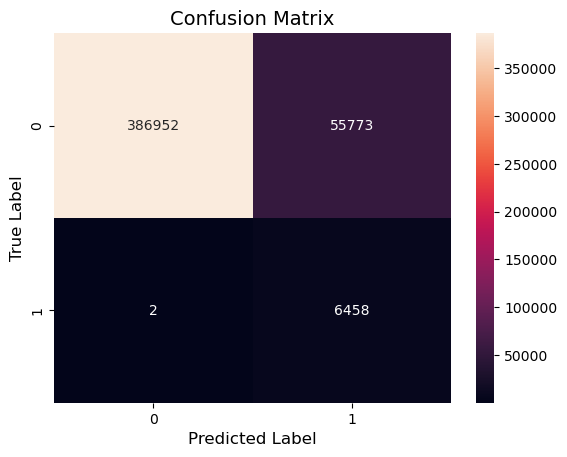

In [142]:
cm = confusion_matrix(y_test, y_pred_brf)
ax = sns.heatmap(cm, annot=True, fmt='.0f')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
plt.show()

In [90]:
brf_metrics_2, y_pred_brf_2, y_pred_proba_brf_2, brf_feature_importances_2 = evaluate_model(model_name='Balanced_RF_reduced', 
                                                  model=BalancedRandomForestClassifier(random_state=40), 
                                                  X_train=X_train_reduced, 
                                                  y_train=y_train, 
                                                  X_test=X_test_reduced, 
                                                  y_test=y_test, 
                                                  params=best_params_brf)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Results for Balanced_RF_reduced model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    442725
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[386837  55888]
 [     0   6460]]


In [91]:
brf_feature_importances_2.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
0,cancelled_sum_10D,0.806681
1,month_encoded,0.057199
9,quarter,0.032384
6,visibility_dest,0.026716
8,visibility_origin,0.024545
7,dep_delay_max_10D,0.014945
5,origin_encoded,0.013526
3,airline_ops_encoded,0.011713
2,origin_weather_impact_category,0.007203
4,dest_weather_impact_category,0.005087


In [92]:
brf_feature_importances.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
23,cancelled_sum_10D,0.628241
15,n_flights_10D,0.079726
14,month_encoded,0.059549
16,quarter,0.027636
18,visibility_dest,0.018697
17,visibility_origin,0.016261
13,temperature_2m_origin,0.015920
12,temperature_2m_dest,0.012226
33,day_of_month,0.010745
0,dep_delay_max_10D,0.009511


In [93]:
model_results = pd.concat([model_results, brf_metrics], axis=0, ignore_index=True)

In [94]:
easy_ensemble_param_grid = {
    'n_estimators': [10, 50, 100], 
    'replacement': [True, False],
    'sampling_strategy': ['auto', 0.5, 0.7]
}

best_model_ee, best_params_ee = random_grid_search_model(EasyEnsembleClassifier(random_state=40), 
                                                           params=easy_ensemble_param_grid, 
                                                           X_train=X_train_sample, 
                                                           y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [95]:
best_params_ee

{'sampling_strategy': 0.5, 'replacement': False, 'n_estimators': 10}

In [96]:
ee_metrics, y_pred_ee, y_pred_proba_ee, _ = evaluate_model(model_name='Easy_Ensemble_grid_search', 
                                                  model=EasyEnsembleClassifier(random_state=40), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params_ee)
    


Results for Easy_Ensemble_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    442725
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[387901  54824]
 [    25   6435]]


In [97]:
model_results = pd.concat([model_results, brf_metrics], axis=0, ignore_index=True)

In [98]:
model_results.sort_values('f1', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987800,0.858200,0.18270,0.30120,0.977400,0.527700,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",74.75960
4,RF_grid_search,"(DecisionTreeClassifier(criterion='entropy', m...",0.878300,0.105500,0.99780,0.19080,0.970700,0.369700,"{'class_weight': 'balanced_subsample', 'criter...",57.62740
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877600,0.105000,0.99850,0.19010,0.973000,0.363200,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",15.05220
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.99969,0.18803,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.68713
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.99969,0.18803,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.68713
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875400,0.103500,1.00000,0.18760,0.966500,0.272800,"{'estimator': None, 'n_estimators': 10, 'n_job...",25.73460
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986400,0.710000,0.09550,0.16840,0.971800,0.379900,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",210.11070


In [99]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875400,0.103500,1.00000,0.18760,0.966500,0.272800,"{'estimator': None, 'n_estimators': 10, 'n_job...",25.73460
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.99969,0.18803,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.68713
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.99969,0.18803,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.68713
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877600,0.105000,0.99850,0.19010,0.973000,0.363200,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",15.05220
4,RF_grid_search,"(DecisionTreeClassifier(criterion='entropy', m...",0.878300,0.105500,0.99780,0.19080,0.970700,0.369700,"{'class_weight': 'balanced_subsample', 'criter...",57.62740
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987800,0.858200,0.18270,0.30120,0.977400,0.527700,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",74.75960
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986400,0.710000,0.09550,0.16840,0.971800,0.379900,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",210.11070


## Additional Class Imbalance Techniques

In [100]:
undersampler = RandomUnderSampler(random_state=40)
X_train_rus, y_train_rus = undersampler.fit_resample(X_train, y_train)

rf_metrics_rus, y_pred_rus, y_pred_proba_rus, _ = evaluate_model(model_name='RF_random_undersample', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_rus, 
                                                  y_train=y_train_rus, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)

Results for RF_random_undersample model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    442725
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[386866  55859]
 [     0   6460]]


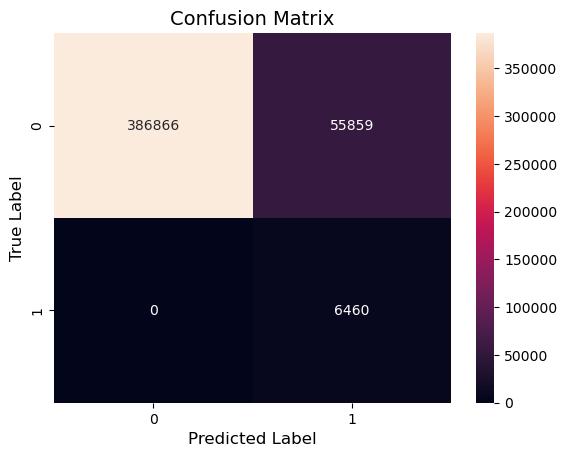

In [141]:
cm = confusion_matrix(y_test, y_pred_rus)
ax = sns.heatmap(cm, annot=True, fmt='.0f')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
plt.show()

In [101]:
model_results = pd.concat([model_results, rf_metrics_rus], axis=0, ignore_index=True)

In [102]:
undersampler_nm = NearMiss(version=1)

X_train_nm1, y_train_nm1 = undersampler_nm.fit_resample(X_train, y_train)

In [103]:
rf_metrics_nm1, y_pred_nm1, y_pred_proba_nm1, _ = evaluate_model(model_name='RF_undersample_nm_1', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_nm1, 
                                                  y_train=y_train_nm1, 
                                                  X_test=X_test, 
                                                  y_test=y_test,
                                                  params=rf_best_params)

Results for RF_undersample_nm_1 model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    442725
           1       0.12      0.73      0.21      6460

    accuracy                           0.92    449185
   macro avg       0.56      0.83      0.59    449185
weighted avg       0.98      0.92      0.95    449185


Confusion matrix: 
 [[409564  33161]
 [  1731   4729]]


In [104]:
model_results = pd.concat([model_results, rf_metrics_nm1], axis=0, ignore_index=True)

In [105]:
tomek = TomekLinks()

X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

In [106]:
rf_tomek_metrics, y_pred_tomek, y_pred_proba_tomek, _ = evaluate_model(model_name='RF_tomek', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_tomek, 
                                                  y_train=y_train_tomek, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)

Results for RF_tomek model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    442725
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion matrix: 
 [[387934  54791]
 [     8   6452]]


In [107]:
model_results = pd.concat([model_results, rf_tomek_metrics], axis=0, ignore_index=True)

In [108]:
undersampler_nm_3 = NearMiss(version=3, n_neighbors=10)

X_train_undersampled_3, y_train_undersampled_3 = undersampler_nm_3.fit_resample(X_train, y_train)

In [109]:
rf_nm3_metrics, y_pred_nm3, y_pred_proba_nm3, _ = evaluate_model(model_name='RF_undersample_nm_3', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_undersampled_3, 
                                                  y_train=y_train_undersampled_3, 
                                                  X_test=X_test, 
                                                  y_test=y_test)

Results for RF_undersample_nm_3 model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    442725
           1       0.13      0.90      0.22      6460

    accuracy                           0.91    449185
   macro avg       0.56      0.91      0.59    449185
weighted avg       0.99      0.91      0.94    449185


Confusion matrix: 
 [[402605  40120]
 [   633   5827]]


In [110]:
model_results = pd.concat([model_results, rf_nm3_metrics], axis=0, ignore_index=True)

In [111]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875400,0.103500,1.000000,0.187600,0.966500,0.272800,"{'estimator': None, 'n_estimators': 10, 'n_job...",25.734600
7,RF_random_undersample,"(DecisionTreeClassifier(criterion='entropy', m...",0.875644,0.103660,1.000000,0.187848,0.971025,0.361568,"{'class_weight': 'balanced_subsample', 'criter...",3.465902
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.999690,0.188030,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.687130
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_features='sqrt', m...",0.875831,0.103775,0.999690,0.188030,0.972655,0.379964,"{'max_depth': None, 'max_features': 'sqrt', 'm...",14.687130
9,RF_tomek,"(DecisionTreeClassifier(criterion='entropy', m...",0.878003,0.105351,0.998762,0.190597,0.971024,0.371092,"{'class_weight': 'balanced_subsample', 'criter...",54.993391
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877600,0.105000,0.998500,0.190100,0.973000,0.363200,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",15.052200
4,RF_grid_search,"(DecisionTreeClassifier(criterion='entropy', m...",0.878300,0.105500,0.997800,0.190800,0.970700,0.369700,"{'class_weight': 'balanced_subsample', 'criter...",57.627400
10,RF_undersample_nm_3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.909273,0.126820,0.902012,0.222375,0.958713,0.184197,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",6.644989
8,RF_undersample_nm_1,"(DecisionTreeClassifier(criterion='entropy', m...",0.922322,0.124809,0.732043,0.213258,0.950646,0.209315,"{'class_weight': 'balanced_subsample', 'criter...",3.390919
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987800,0.858200,0.182700,0.301200,0.977400,0.527700,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",74.759600


In [155]:
model_results_formated = model_results
model_results_formated[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'auprc', 'training_testing_time_seconds']] = round(model_results_formated[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'auprc', 'training_testing_time_seconds']], 4)
model_results_formated = model_results_formated.sort_values(['recall', 'f1'], ascending=False)
model_results_formated.to_csv('./model_results/models_formatted.csv', index=False)

In [113]:
model_results.to_csv('./model_results/model_results.10.27.csv', index=False)


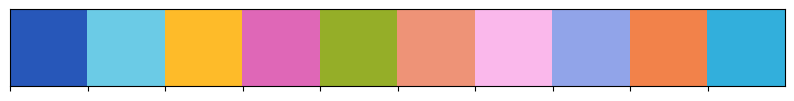

In [146]:
palette = {
    'Saphire': '#2757B9',
    'Sky blue': '#6bcbe6',
    'Selective yellow': '#febb29',
    'Sky magenta': '#df67b7',
    'Apple green': '#95ae28',
    'Atomic tangerine': '#ee9377',
    'Lavender pink': '#fab8eb',
    'Vista Blue': '#91a4e9',
    'Orange (Crayola)': '#f2824a',
    'Process Cyan': '#32afdc'
}
color_codes = list(palette.values())

palette = sns.color_palette(color_codes)
sns.set_palette(palette)

sns.palplot(sns.color_palette(color_codes))

# Adjusting Probability Thresholds

### NearMiss Version 3

In [114]:
baseline = len(y[y==1])/len(y)

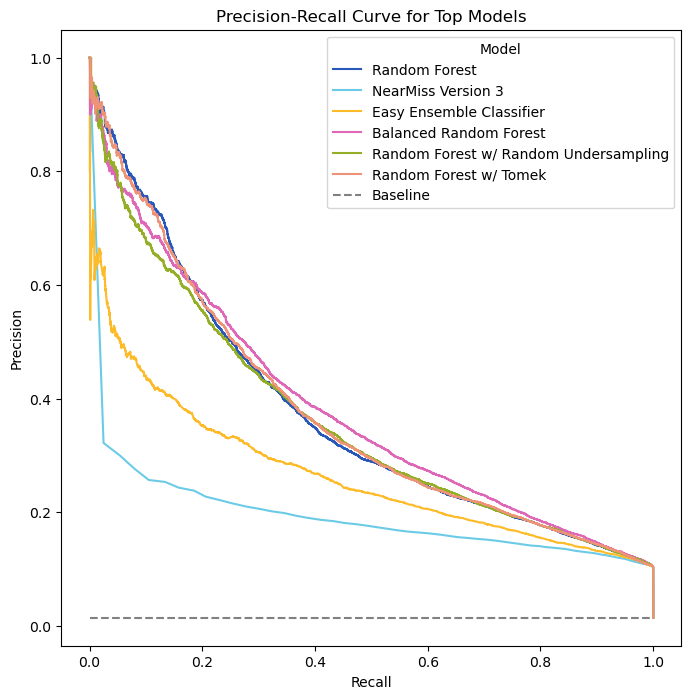

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf_base[:,1])
plt.plot(recall_rf, precision_rf, label='Random Forest Base')

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf[:,1])
plt.plot(recall_rf, precision_rf, label='Random Forest')

precision_nm3, recall_nm3, _ = precision_recall_curve(y_test, y_pred_proba_nm3[:,1])
plt.plot(recall_nm3, precision_nm3, label='NearMiss Version 3')

precision_ee, recall_ee, _ = precision_recall_curve(y_test, y_pred_proba_ee[:,1])
plt.plot(recall_ee, precision_ee, label='Easy Ensemble Classifier')

precision_brf, recall_brf, _ = precision_recall_curve(y_test, y_pred_proba_brf[:,1])
plt.plot(recall_brf, precision_brf, label='Balanced Random Forest')

precision_rus, recall_rus, _ = precision_recall_curve(y_test, y_pred_proba_rus[:,1])
plt.plot(recall_rus, precision_rus, label='Random Forest w/ Random Undersampling')

precision_tomek, recall_tomek, _ = precision_recall_curve(y_test, y_pred_proba_tomek[:,1])
plt.plot(recall_tomek, precision_tomek, label='Random Forest w/ Tomek')

plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline', color='grey')

plt.title('Precision-Recall Curve for Top Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(title='Model')
# show the plot
plt.show()

In [116]:
def evaluate_with_custom_threshold(y_test, y_pred_proba, threshold):
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_custom))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_custom))

    return y_pred_custom

In [157]:
evaluate_with_custom_threshold(y_test, y_pred_proba_brf[:,1], 0.70)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    442725
           1       0.13      0.95      0.22      6460

    accuracy                           0.90    449185
   macro avg       0.56      0.93      0.59    449185
weighted avg       0.99      0.90      0.94    449185


Confusion Matrix:
[[400227  42498]
 [   314   6146]]


array([0, 0, 0, ..., 0, 0, 0])

In [118]:
evaluate_with_custom_threshold(y_test, y_pred_proba_brf[:,1], 0.5)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    442725
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    449185
   macro avg       0.55      0.94      0.56    449185
weighted avg       0.99      0.88      0.92    449185


Confusion Matrix:
[[386952  55773]
 [     2   6458]]


array([0, 0, 0, ..., 0, 0, 0])

In [119]:
evaluate_with_custom_threshold(y_test, y_pred_proba_ee[:,1], 0.53)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    442725
           1       0.13      0.91      0.23      6460

    accuracy                           0.91    449185
   macro avg       0.56      0.91      0.59    449185
weighted avg       0.99      0.91      0.94    449185


Confusion Matrix:
[[403548  39177]
 [   579   5881]]


array([0, 0, 0, ..., 0, 0, 0])

In [167]:
evaluate_with_custom_threshold(y_test, y_pred_proba_rf[:,1], 0.65)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    442725
           1       0.12      0.95      0.22      6460

    accuracy                           0.90    449185
   macro avg       0.56      0.93      0.58    449185
weighted avg       0.99      0.90      0.94    449185


Confusion Matrix:
[[399815  42910]
 [   333   6127]]


array([0, 0, 0, ..., 0, 0, 0])

In [121]:
true_positives = X_test[(y_test == 1) & (y_pred_brf == 1)]
true_negatives = X_test[(y_test == 0) & (y_pred_brf == 0)]
false_positives = X_test[(y_test == 0) & (y_pred_brf == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_brf == 0)]

In [122]:
false_positives

,dep_delay_max_10D,origin_encoded,origin_division_encoded,hour_of_day,dep_window_encoded,wind_gusts_10m_origin,wind_gusts_10m_dest,wind_speed_10m_origin,wind_speed_10m_dest,airline_ops_encoded,airline_mkt_encoded,code_share_flight,temperature_2m_dest,temperature_2m_origin,month_encoded,n_flights_10D,quarter,visibility_origin,visibility_dest,origin_weather_impact_category,dest_weather_impact_category,route_id,distance,cancelled_sum_10D,snow_depth_dest,snow_depth_origin,precipitation_origin,wind_direction_10m_dest,wind_direction_10m_origin,precipitation_dest,is_holiday,day_of_week,div_airport_landings_sum_10D,day_of_month
6,1.590345,-0.306629,-0.170807,-0.007048,-0.230172,-1.048141,-0.570235,-1.209354,-0.465739,0.103091,0.617009,0,1.637072,0.931636,1.997376,-0.597424,0.436934,0.513457,0.383318,0.900034,-0.707410,1.025397,-0.738196,1.241613,-0.097640,-0.098455,-0.05996,0.503885,1.216891,-0.061496,0,-0.986007,-0.124875,0.258290
18,-0.046988,0.511622,0.087278,-0.204590,-1.113213,0.341520,0.218325,0.897398,1.131729,-0.474572,-0.535382,0,0.801559,1.801012,1.304793,-0.597424,-0.462329,0.762865,-0.632589,-0.706343,0.949132,-0.667525,0.476820,1.241613,-0.097640,-0.098455,-0.05996,-0.230894,-0.053427,-0.061496,0,0.514201,-0.124875,1.626769
20,-1.081093,-0.306629,-0.170807,1.375750,1.843912,-0.608555,1.344840,-0.669820,0.745245,-0.611636,-0.400774,0,-0.632361,-0.745417,-1.112765,-0.816417,1.336197,0.202875,-0.351693,-0.706343,-0.707410,1.017942,-0.327054,1.241613,-0.097640,-0.098455,-0.05996,0.242183,1.026844,-0.061496,0,1.514339,-0.124875,-0.882108
32,-0.635853,-0.401950,-0.699338,1.770835,0.487422,0.001195,-1.584097,0.100943,-1.444832,-0.611636,-0.400774,0,0.547518,1.520568,1.304793,0.497545,-0.462329,2.692244,-0.843261,-0.706343,-0.707410,0.187944,1.022964,1.241613,-0.097640,-0.098455,-0.05996,0.956831,-1.073682,-0.061496,0,0.014131,-0.124875,1.512729
39,-0.190614,-0.303242,-0.699338,1.573292,1.843912,-0.693636,-1.302469,-0.053210,-0.852223,0.823655,1.396771,0,-1.445293,-2.433689,0.093819,0.388048,-1.361592,-0.950047,0.285004,0.900034,-0.707410,-0.782457,-0.693707,2.804632,-0.097640,13.904927,-0.05996,0.695129,0.606738,-0.061496,0,-0.485938,-0.124875,0.258290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449141,-0.291152,-0.306629,-0.170807,1.573292,1.843912,0.639305,-0.640642,-0.438591,-0.517270,0.103091,0.617009,0,0.762042,0.567060,1.304793,-1.363902,-0.462329,-0.023004,-0.520231,-0.706343,-0.707410,1.025397,-0.738196,1.241613,-0.097640,-0.098455,-0.05996,1.691610,1.066854,-0.061496,0,-1.486076,-0.124875,1.170609
449151,1.733971,-1.056043,-1.265391,-1.192303,-0.809685,-1.076502,-0.485746,-1.106586,0.101105,-0.611636,-0.400774,0,0.739461,0.101523,0.183208,1.592513,0.436934,-0.785344,0.874886,0.900034,-0.707410,0.295421,2.139797,1.241613,-0.097640,-0.098455,-0.05996,0.946765,-1.753853,-0.061496,0,-0.485938,-0.124875,0.486370
449154,1.260006,2.231095,2.044389,1.573292,1.843912,1.050531,0.021185,-0.155978,-0.826458,0.103091,0.617009,0,-0.446065,1.127947,1.997376,-0.706921,0.436934,0.320520,-0.744947,-0.706343,-0.707410,-0.421508,2.277867,2.804632,-0.097640,-0.098455,-0.05996,1.560758,-0.243474,-0.061496,0,1.514339,-0.124875,0.828490
449159,0.082275,-0.285977,-0.026065,0.585580,0.351529,0.100457,1.063211,-0.207362,0.590651,-0.474572,-0.535382,0,-2.399358,-1.037079,0.297101,-0.597424,-1.361592,-0.870048,0.247552,0.900034,-0.707410,-1.097434,-0.890073,1.241613,0.374875,-0.098455,-0.05996,0.211986,-1.273732,-0.061496,0,-0.485938,-0.124875,-1.680387


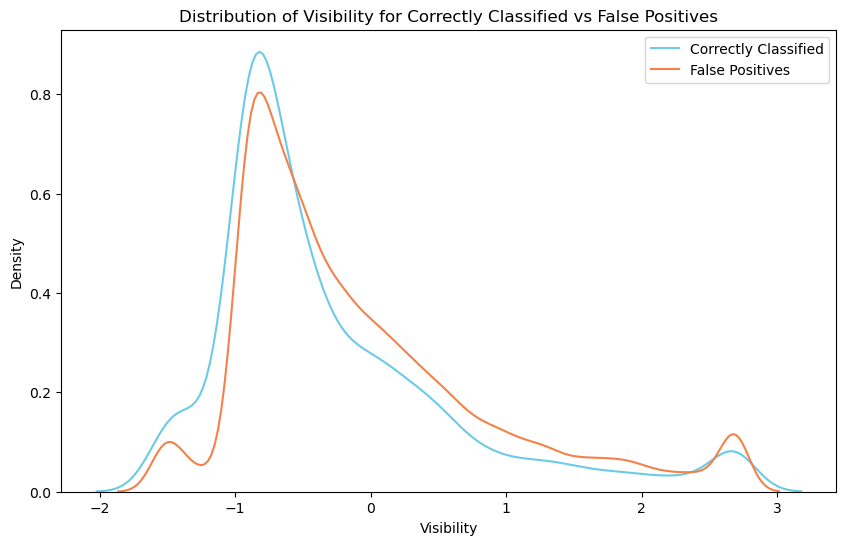

In [160]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['visibility_origin'], label='Correctly Classified', color=palette[1])
sns.kdeplot(false_positives['visibility_origin'], label='False Positives', color=palette[8])
plt.title("Distribution of Visibility for Correctly Classified vs False Positives")
plt.xlabel("Visibility")
plt.legend()
plt.show()

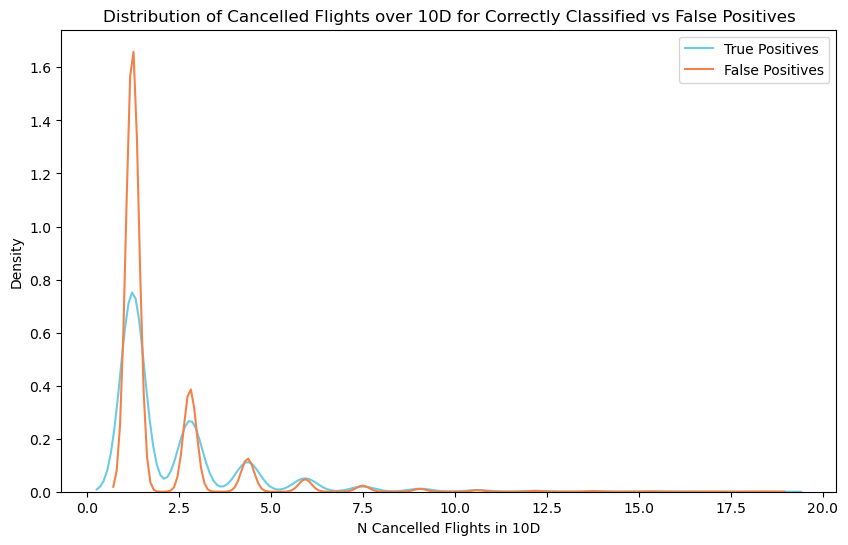

In [162]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['cancelled_sum_10D'], label='True Positives', color=palette[1])
sns.kdeplot(false_positives['cancelled_sum_10D'], label='False Positives', color=palette[8])
plt.title("Distribution of Cancelled Flights over 10D for Correctly Classified vs False Positives")
plt.xlabel("N Cancelled Flights in 10D")
plt.legend()
plt.show()

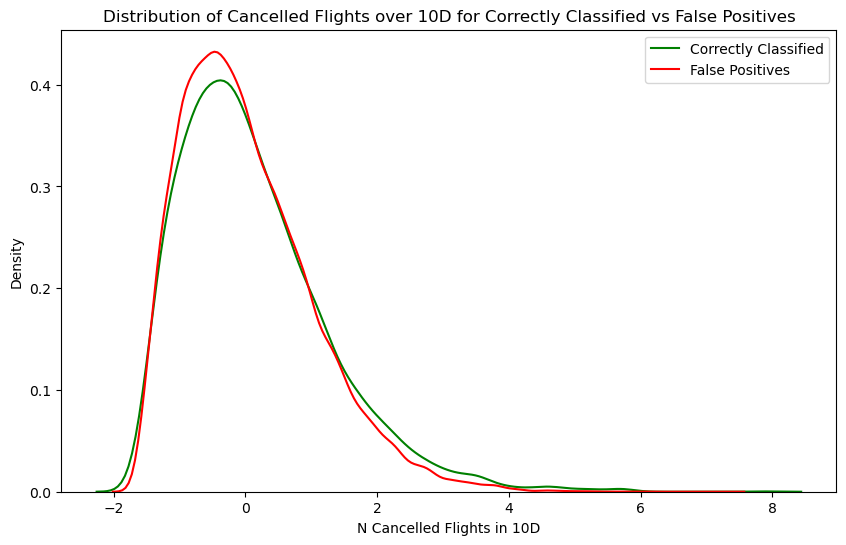

In [125]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['wind_speed_10m_dest'], label='Correctly Classified', color='green')
sns.kdeplot(false_positives['wind_speed_10m_dest'], label='False Positives', color='red')
plt.title("Distribution of Cancelled Flights over 10D for Correctly Classified vs False Positives")
plt.xlabel("N Cancelled Flights in 10D")
plt.legend()
plt.show()

<Axes: >

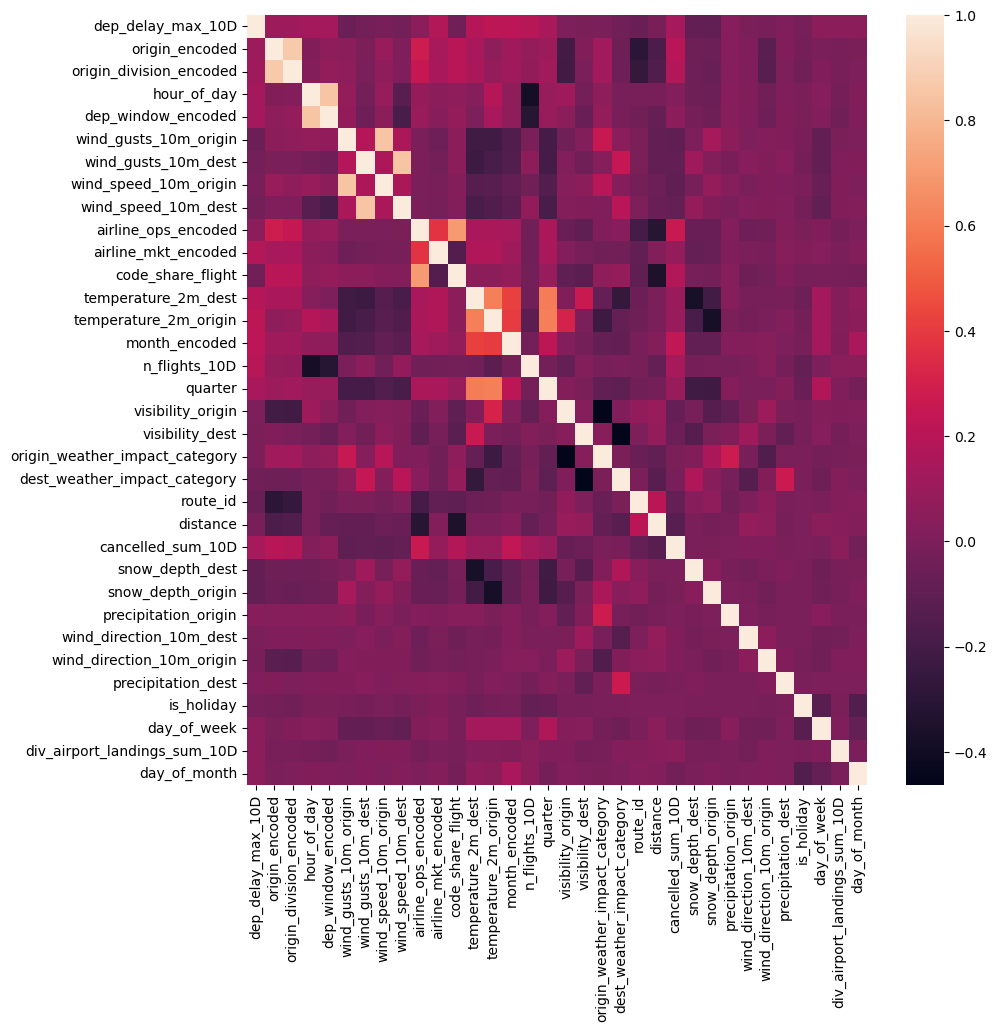

In [126]:
fig, ax = plt.subplots(figsize=(10,10))

true_positive_corr = true_positives.corr()
sns.heatmap(true_positive_corr)

<Axes: >

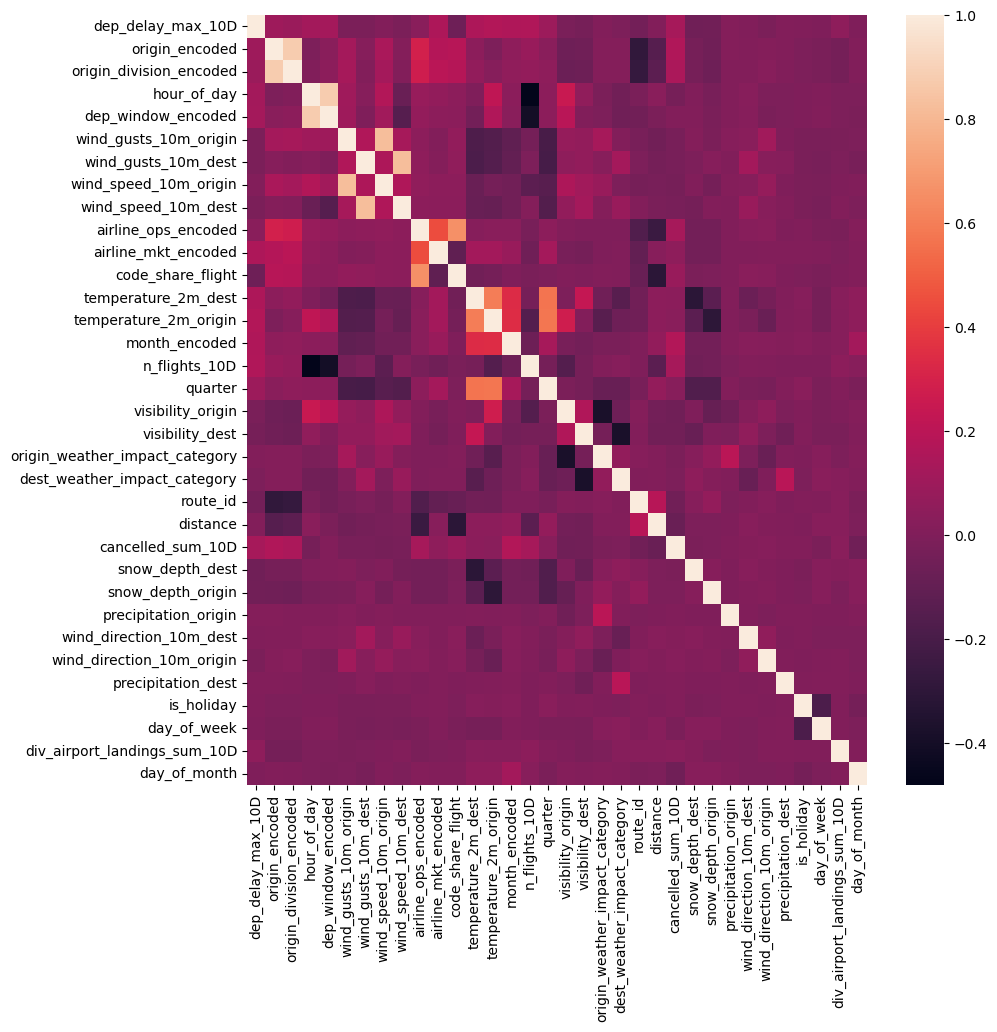

In [127]:
fig, ax = plt.subplots(figsize=(10,10))

false_positive_corr = false_positives.corr()
sns.heatmap(false_positive_corr)

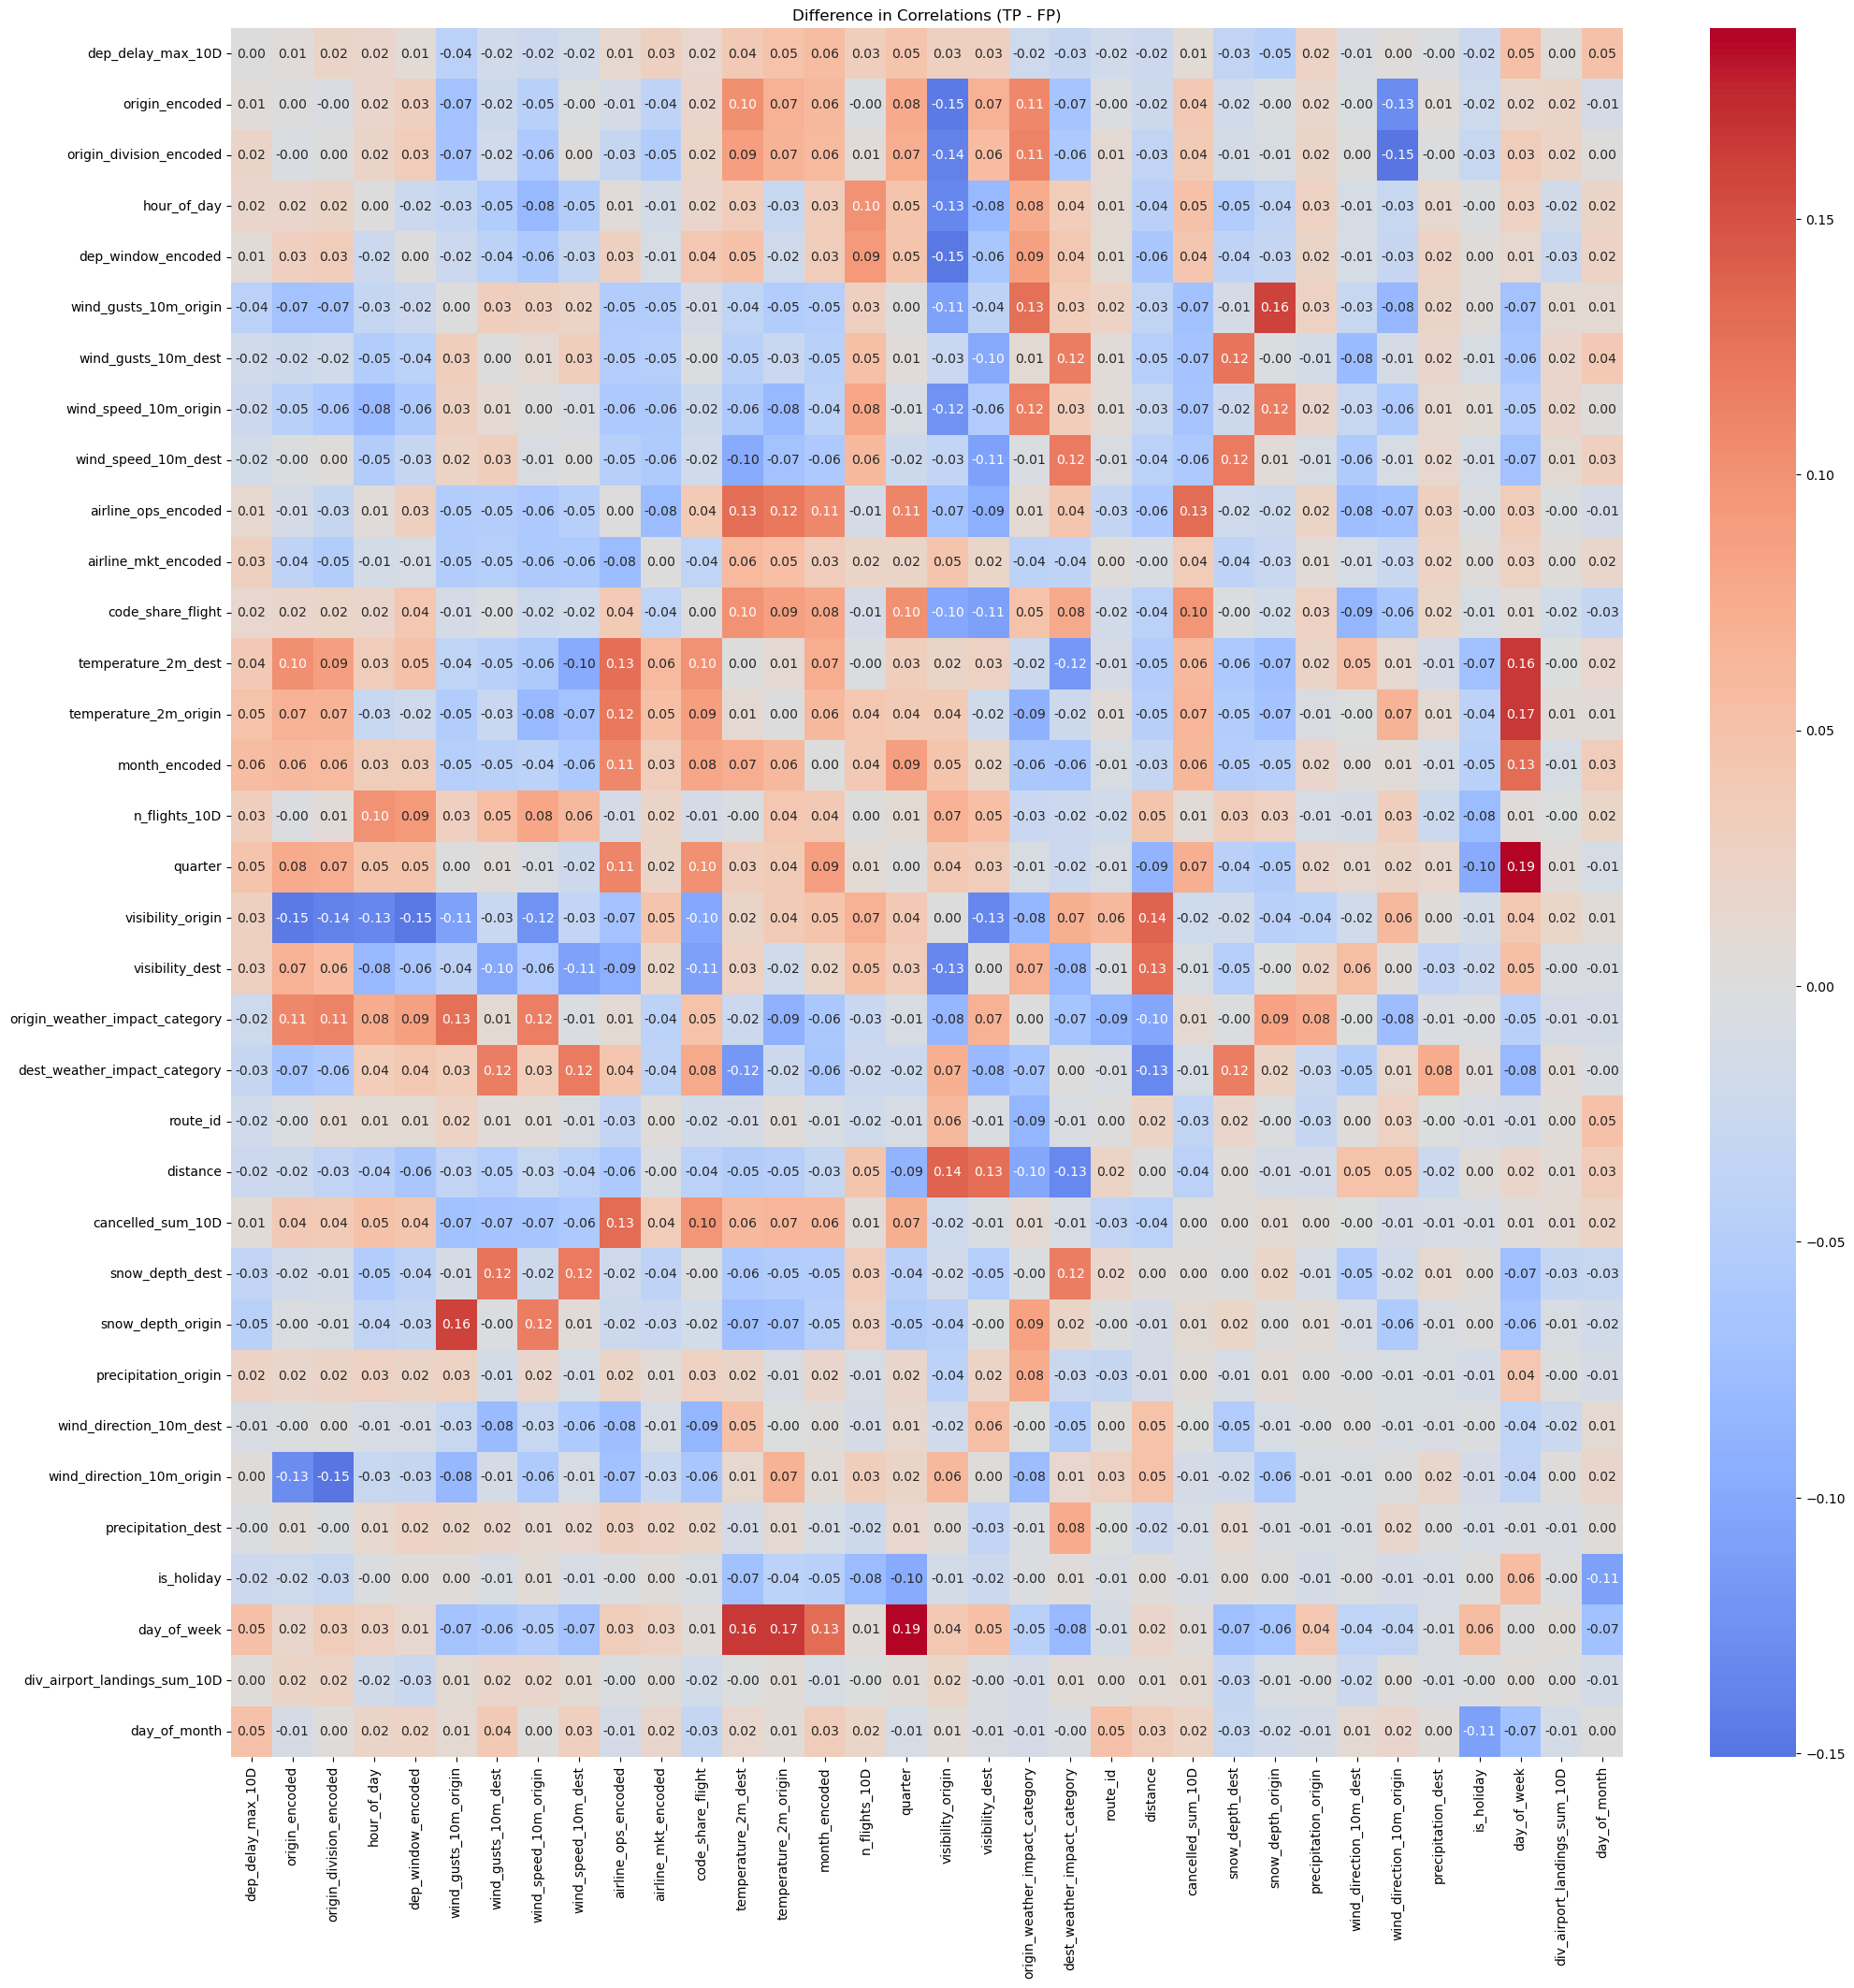

In [128]:
corr_diff = true_positive_corr - false_positive_corr

plt.figure(figsize=(24,24))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Difference in Correlations (TP - FP)")
plt.show()

In [129]:
corr_diff_flat = corr_diff.unstack().reset_index()
corr_diff_flat.columns = ['Feature 1', 'Feature 2', 'Difference']
# Filter out self-correlations (where Feature 1 == Feature 2)
corr_diff_flat = corr_diff_flat[corr_diff_flat['Feature 1'] != corr_diff_flat['Feature 2']]

# Sort by absolute difference to find most significant correlations
corr_diff_flat['Abs Difference'] = corr_diff_flat['Difference'].abs()

# Display the top 10 strongest positive and negative differences
top_positive_diffs = corr_diff_flat.sort_values(by='Difference', ascending=False).head(10)
top_negative_diffs = corr_diff_flat.sort_values(by='Difference', ascending=True).head(10)

In [130]:
top_positive_diffs

,Feature 1,Feature 2,Difference,Abs Difference
1070,day_of_week,quarter,0.187254,0.187254
575,quarter,day_of_week,0.187254,0.187254
1067,day_of_week,temperature_2m_origin,0.165152,0.165152
473,temperature_2m_origin,day_of_week,0.165152,0.165152
439,temperature_2m_dest,day_of_week,0.164845,0.164845
1066,day_of_week,temperature_2m_dest,0.164845,0.164845
855,snow_depth_origin,wind_gusts_10m_origin,0.160641,0.160641
195,wind_gusts_10m_origin,snow_depth_origin,0.160641,0.160641
600,visibility_origin,distance,0.137973,0.137973
765,distance,visibility_origin,0.137973,0.137973


In [131]:
top_negative_diffs

,Feature 1,Feature 2,Difference,Abs Difference
954,wind_direction_10m_origin,origin_division_encoded,-0.150712,0.150712
96,origin_division_encoded,wind_direction_10m_origin,-0.150712,0.150712
153,dep_window_encoded,visibility_origin,-0.147852,0.147852
582,visibility_origin,dep_window_encoded,-0.147852,0.147852
51,origin_encoded,visibility_origin,-0.145849,0.145849
579,visibility_origin,origin_encoded,-0.145849,0.145849
580,visibility_origin,origin_division_encoded,-0.139007,0.139007
85,origin_division_encoded,visibility_origin,-0.139007,0.139007
629,visibility_dest,visibility_origin,-0.134851,0.134851
596,visibility_origin,visibility_dest,-0.134851,0.134851


<Axes: >

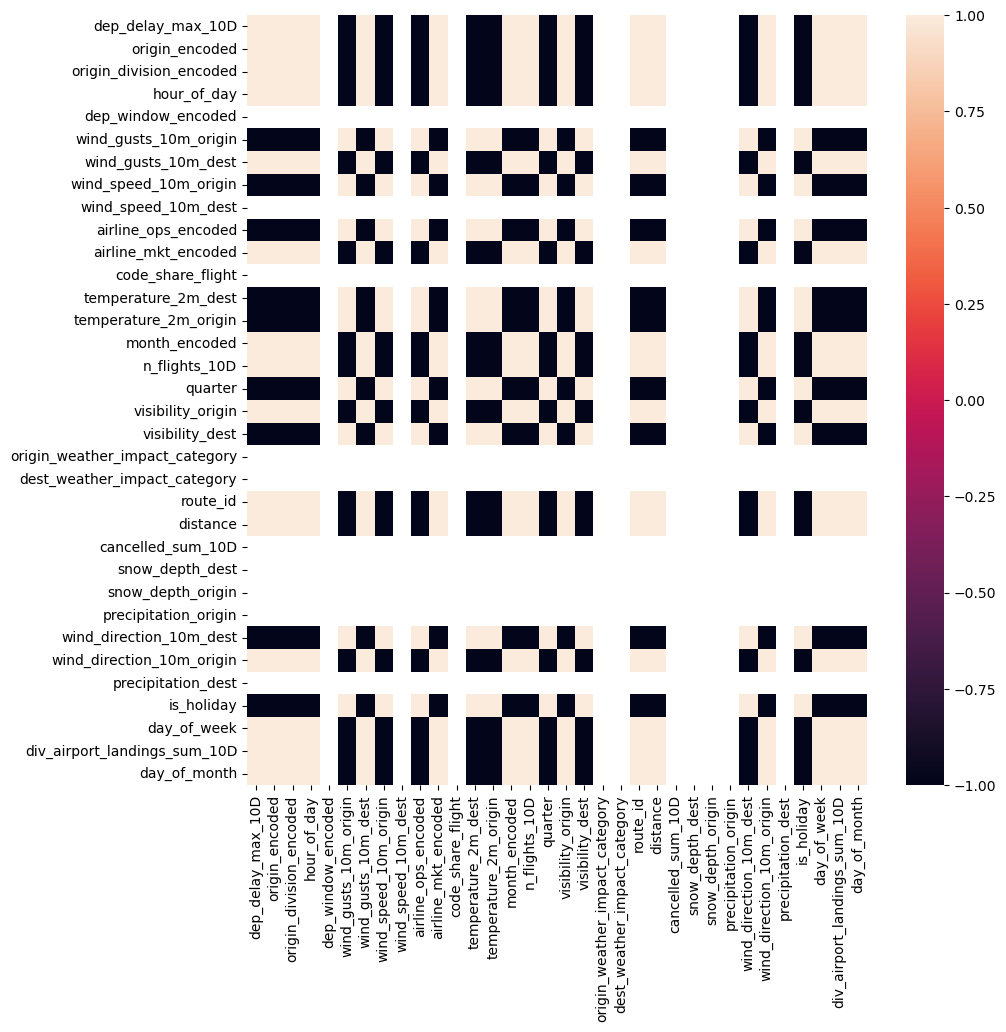

In [132]:
fig, ax = plt.subplots(figsize=(10,10))
false_negative_corr = false_negatives.corr()
sns.heatmap(false_negative_corr)